In [1]:
import numpy as  np
import pandas as pd

import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Linear, Softmax, Conv3d
from torch.utils.data import dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
halocat_fn = '../../fun/taudamp_z008.00_nf0.08784_1000_300Mpc_master_bubnoadded.csv'

In [3]:
halocat = pd.read_csv(halocat_fn)

In [4]:
halocat.head()

,Mass,x,y,z,Rbub,Muv,Trans_noCGM,vint_noCGM,vobs_noCGM,Wobs_noCGM,flux_Lya_noCGM,Trans,vint,vobs,Wint,Wobs,flux_Lya,flux_cont,bub_no
0,9.651514e+11,0.4714,0.3713,0.6524,0.0,-22.929366,1.0,166.022223,166.022223,88.544813,1.431228e-16,1.0,329.065415,329.065415,88.544813,88.544813,1.431228e-16,1.351379,6.0
1,9.651514e+11,0.5321,0.6134,0.7606,0.0,-22.991505,1.0,207.033087,207.033087,0.000000,0.000000e+00,1.0,329.065415,329.065415,0.000000,0.000000,0.000000e+00,1.430979,21.0
2,7.251325e+11,0.1778,0.6328,0.5616,0.0,-22.775194,1.0,196.030173,196.030173,110.626469,1.551444e-16,1.0,299.057465,299.057465,110.626469,110.626469,1.551444e-16,1.172489,6.0
3,7.251325e+11,0.3087,0.7778,0.7877,0.0,-22.194326,1.0,164.021693,164.021693,0.000000,0.000000e+00,1.0,299.057465,299.057465,0.000000,0.000000,0.000000e+00,0.686691,11.0
4,7.251325e+11,0.3408,0.8939,0.0635,0.0,-22.605161,1.0,200.031233,200.031233,0.000000,0.000000e+00,1.0,299.057465,299.057465,0.000000,0.000000,0.000000e+00,1.002525,13.0


In [49]:
x = halocat['x'].to_numpy()
y = halocat['y'].to_numpy()
z = halocat['z'].to_numpy()
Muv = halocat['Muv'].to_numpy()
flux_Lya = halocat['flux_Lya'].to_numpy()

x = x[Muv < -18]
y = y[Muv < -18]
z = z[Muv < -18]
flux_Lya = flux_Lya[Muv < -18]
Muv = Muv[Muv < -18]

x = x[flux_Lya > 1e-19]
y = y[flux_Lya > 1e-19]
z = z[flux_Lya > 1e-19]
Muv = Muv[flux_Lya > 1e-19]
flux_Lya = flux_Lya[flux_Lya > 1e-19]

In [50]:
flux_Lya = np.log10(flux_Lya)
flux_Lya -= flux_Lya.mean()
flux_Lya /= flux_Lya.std()
Muv -= Muv.mean()
Muv /= Muv.std()

In [51]:
from scipy.stats import truncnorm

In [52]:
a_trunc = 0
b_trunc = 1
loc = 0.7
scale = 0.1
a, b = (a_trunc - loc) / scale, (b_trunc - loc) / scale

In [53]:
# x = truncnorm.rvs(a, b, loc=loc, scale=scale, size=len(x))
# y = truncnorm.rvs(a, b, loc=loc, scale=scale, size=len(y))
# z = truncnorm.rvs(a, b, loc=loc, scale=scale, size=len(z))

In [54]:
ipt_x = torch.tensor(np.array([x, Muv, flux_Lya]).T, device=device, dtype=torch.float32)
ipt_y = torch.tensor(np.array([y, Muv, flux_Lya]).T, device=device, dtype=torch.float32)
ipt_z = torch.tensor(np.array([z, Muv, flux_Lya]).T, device=device, dtype=torch.float32)

In [55]:
class HeadNetwork(nn.Module):

    def __init__(self, image_size: int):
        super().__init__()
        self.l1 = Linear(3, image_size, device=device)
        self.l2 = Linear(3, image_size, device=device)
        self.l3 = Linear(3, image_size, device=device)
        # self.a1 = Softmax()
        # self.a2 = Softmax()

    def forward(self, x: Tensor, y: Tensor, z: Tensor) -> Tensor:
        x = self.l1(x)
        y = self.l2(y)
        z = self.l3(z)
        out = torch.einsum('bq,rt->qt', x, y)
        out = out - out.mean()
        out = out/out.std()
        out = torch.einsum('br,qt->qtr', z, out)
        out = out - out.mean()
        out = out/out.std()
        return out

In [56]:
class MiniHeadNetwork(nn.Module):

    def __init__(self, image_size: int):
        super().__init__()
        self.l1 = Linear(3, image_size, device=device)
        # self.a1 = Softmax()
        self.l2 = Linear(image_size, image_size, device=device)
        # self.a2 = Softmax()
        # self.l3 = Linear(image_size, image_size, device=device)
        # self.a3 = Softmax()
        # self.a2 = Softmax()

    def forward(self, x: Tensor) -> Tensor:
        out = self.l1(x)
        out = self.l2(out)
        # out = self.a1(out)
        # out = self.l2(out)
        # out = self.a2(out)
        # out = self.l3(out)
        # out = self.a3(torch.mean(out, axis=0))
        out = torch.sum(out, axis=0)
        out = out - out.mean()
        out = out / out.std()
        return out

In [57]:
model = HeadNetwork(image_size=128)
# model = MiniHeadNetwork(image_size=128)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

1536


In [58]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [59]:
labels = torch.tensor(np.load('../../fun/xHI_reference.npy'), device=device)
# labels, _ = np.histogram(x*128, 128)
# labels = torch.tensor(labels, device=device, dtype=torch.float32)
# labels = labels - labels.mean()
# labels = labels/labels.std()

In [60]:
i = 0
outputs_dict = []
while i < 1000:
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(ipt_x, ipt_y, ipt_z)
    # outputs = model(ipt_x)

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()
    if i%10==0:
        print(f'Epoch {i} Loss {loss.item()}')
        outputs_dict += [outputs.detach().cpu().numpy()]
    i += 1

Epoch 0 Loss 374.60693359375
Epoch 10 Loss 364.76904296875
Epoch 20 Loss 355.83172607421875
Epoch 30 Loss 352.1771545410156
Epoch 40 Loss 350.207763671875
Epoch 50 Loss 348.9862060546875
Epoch 60 Loss 348.2814025878906
Epoch 70 Loss 347.7455749511719
Epoch 80 Loss 347.352294921875
Epoch 90 Loss 347.03192138671875
Epoch 100 Loss 346.7352294921875
Epoch 110 Loss 346.4676513671875
Epoch 120 Loss 346.22576904296875
Epoch 130 Loss 346.0000305175781
Epoch 140 Loss 345.78607177734375
Epoch 150 Loss 345.58465576171875
Epoch 160 Loss 345.39996337890625
Epoch 170 Loss 345.234619140625
Epoch 180 Loss 345.11236572265625
Epoch 190 Loss 345.09722900390625
Epoch 200 Loss 345.0973205566406
Epoch 210 Loss 345.0918273925781
Epoch 220 Loss 345.0916748046875
Epoch 230 Loss 345.09130859375
Epoch 240 Loss 345.0911560058594
Epoch 250 Loss 345.0910949707031
Epoch 260 Loss 345.091064453125
Epoch 270 Loss 345.09100341796875
Epoch 280 Loss 345.0909423828125
Epoch 290 Loss 345.09088134765625
Epoch 300 Loss 345.09

In [61]:
import matplotlib.pyplot as plt

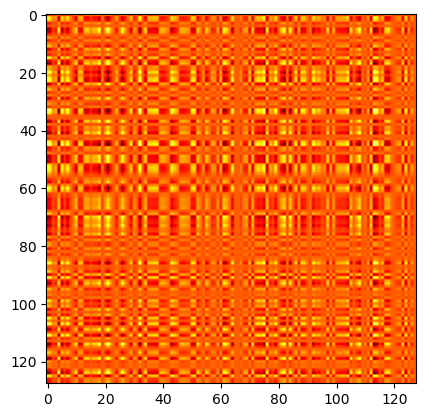

In [62]:
plt.imshow(outputs_dict[0][30], cmap='hot')
plt.show()

# plt.plot(outputs_dict[0], color='blue', label='Prediction')
# plt.plot(labels.detach().cpu().numpy(), color='orange', label='Truth')
# plt.legend()
# plt.ylim(-10, 10)

In [16]:
X = ipt_x.detach().cpu().numpy()

In [17]:
W = np.ones((3, 128))

In [18]:
(X@W).shape

(31964, 128)

In [ ]:
# HEAD NETWORK 1: fixed table size
# HEAD NETWORK 2: full (variable) table size